# Test Delineate-Anything avec YOLO

Ce notebook teste le modèle **Delineate-Anything** avec l'interface YOLO sur nos images TCI Sentinel-2.

## Objectif
- Charger le modèle pré-entraîné `MykolaL/DelineateAnything`
- Tester sur les fichiers TCI.tif téléchargés
- Visualiser les limites de champs détectées

In [27]:
# Installation des dépendances
!pip install ultralytics rasterio shapely numpy opencv-python pillow tqdm

In [28]:
import os
import math
import json
import numpy as np
import rasterio
from rasterio.transform import rowcol
from rasterio.transform import Affine
import cv2
from shapely.geometry import Polygon, mapping
from ultralytics import YOLO
from pathlib import Path

In [29]:
!wget https://huggingface.co/MykolaL/DelineateAnything/blob/main/DelineateAnything.pt

--2025-08-20 20:36:55--  https://huggingface.co/MykolaL/DelineateAnything/blob/main/DelineateAnything.pt
Resolving huggingface.co (huggingface.co)... 13.35.202.97, 13.35.202.121, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67994 (66K) [text/html]
Saving to: ‘DelineateAnything.pt.1’

DelineateAnything.p 100%[===================>]  66.40K  --.-KB/s    in 0.004s  

2025-08-20 20:36:56 (17.7 MB/s) - ‘DelineateAnything.pt.1’ saved [67994/67994]



In [30]:
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

print("🛰️ Chargement du modèle Delineate-Anything depuis le fichier .pt...")

# Charger le modèle Delineate-Anything à partir du fichier .pt
model = YOLO("DelineateAnything.pt")

print("✅ Modèle chargé avec succès!")

🛰️ Chargement du modèle Delineate-Anything depuis le fichier .pt...
✅ Modèle chargé avec succès!


In [31]:
import requests
from tqdm import tqdm

def download_tci_image(url, filename):
    """Télécharge une image TCI depuis l'URL"""
    if Path(filename).exists():
        print(f"✅ {filename} déjà présent")
        return filename

    print(f"⬇️  Téléchargement de {filename}...")

    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as f, tqdm(
        desc=f"Téléchargement {filename}",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

    print(f"✅ {filename} téléchargé avec succès!")
    return filename

# URLs des images TCI Sentinel-2
tci_urls = {
    "TCI_EastAfrica_20200701.tif": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/Q/WD/2020/7/S2A_36QWD_20200701_0_L2A/TCI.tif",
    "TCI_Asia_20230815.tif": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/WN/2023/8/S2A_54TWN_20230815_0_L2A/TCI.tif"
}

# Télécharger les images TCI
tci_files = []
for filename, url in tci_urls.items():
    try:
        downloaded_file = download_tci_image(url, filename)
        tci_files.append(downloaded_file)
    except Exception as e:
        print(f"❌ Erreur téléchargement {filename}: {e}")

print(f"\n📁 {len(tci_files)} fichiers TCI disponibles pour le test")

✅ TCI_EastAfrica_20200701.tif déjà présent
✅ TCI_Asia_20230815.tif déjà présent

📁 2 fichiers TCI disponibles pour le test


📖 Chargement de TCI_Asia_20230815.tif...
✅ Image chargée: (10980, 10980, 3)
   CRS: EPSG:32654
   Résolution: (10.0, 10.0)
   Bounds: BoundingBox(left=499980.0, bottom=4690200.0, right=609780.0, top=4800000.0)


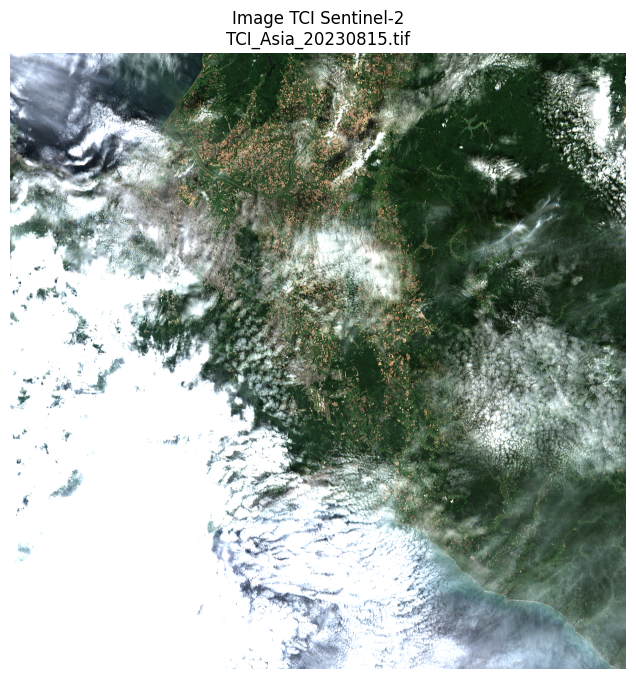

In [32]:
def load_and_display_tci(tci_path):
    """Charge et affiche une image TCI"""
    if not Path(tci_path).exists():
        print(f"❌ Fichier introuvable: {tci_path}")
        return None

    print(f"📖 Chargement de {tci_path}...")

    with rasterio.open(tci_path) as src:
        # Lire les 3 bandes RGB
        rgb_data = src.read([1, 2, 3])  # Bandes R, G, B

        # Transposer pour matplotlib (H, W, C)
        rgb_image = np.transpose(rgb_data, (1, 2, 0))

        # Normaliser si nécessaire
        if rgb_image.dtype == np.uint16:
            rgb_image = (rgb_image / 65535.0 * 255).astype(np.uint8)
        elif rgb_image.max() > 255:
            rgb_image = (rgb_image / rgb_image.max() * 255).astype(np.uint8)

        print(f"✅ Image chargée: {rgb_image.shape}")
        print(f"   CRS: {src.crs}")
        print(f"   Résolution: {src.res}")
        print(f"   Bounds: {src.bounds}")

        # Affichage
        plt.figure(figsize=(12, 8))
        plt.imshow(rgb_image)
        plt.title(f"Image TCI Sentinel-2\n{Path(tci_path).name}")
        plt.axis('off')
        plt.show()

        return rgb_image, src.crs, src.transform

# Charger la première image TCI disponible
if tci_files:
    test_image_path = tci_files[1]
    rgb_array, crs, transform = load_and_display_tci(test_image_path)
else:
    print("❌ Aucun fichier TCI disponible pour le test")

In [33]:
tile_size = 1024         # ↑ si GPU ok (1280), ↓ si OOM (512)
overlap    = 128         # IMPORTANT pour éviter coupures de champs
stride     = tile_size - overlap
conf_thr   = 0.35        # commence plus bas pour remonter le rappel
iou_thr    = 0.5

In [34]:
# --- lecture du GeoTIFF en RGB uint8 pour servir de fond ---
with rasterio.open(test_image_path) as src:
    # rgb = src.read([1,2,3]).transpose(1,2,0)  # (H,W,3)
    # if rgb.dtype == np.uint16:
    #     rgb = (rgb.astype(np.float32)/65535.0*255).astype(np.uint8)
    # elif rgb.max() > 255:
    #     rgb = (rgb.astype(np.float32)/rgb.max()*255).astype(np.uint8)
    # calcule un étirement global (évite contrastes différents par tuile)
    bands = [1,2,3] if src.count == 3 else [4,3,2]  # S2: [4,3,2] = R,G,B
    crs = src.crs
    transform = src.transform
    H, W = src.height, src.width
    preview = src.read(bands, out_shape=(len(bands), H//8, W//8)).transpose(1,2,0).astype(np.float32)
    lo = float(np.percentile(preview, 0.5))
    hi = float(np.percentile(preview, 99.5))

    def to_uint8_global(img):
        x = img.astype(np.float32)
        x = np.clip((x - lo) / max(1e-6, (hi - lo)), 0, 1) * 255.0
        return x.round().astype(np.uint8)

    # fond overlay en 8-bit (même étirement partout)
    rgb = to_uint8_global(src.read(bands).transpose(1,2,0))

overlay = rgb.copy()
features = []  # pour GeoJSON
boundary_layer = np.zeros_like(overlay, dtype=np.uint8)

def draw_outline(poly_pts, layer, color_fg=(255,255,255), color_bg=(0,0,0)):
    pts = poly_pts.astype(np.int32).reshape(-1,1,2)
    cv2.polylines(layer, [pts], True, color_bg, 6, lineType=cv2.LINE_AA)  # halo noir
    cv2.polylines(layer, [pts], True, color_fg, 3, lineType=cv2.LINE_AA)  # trait blanc


print("🚀 Lancement de la détection (tuile par tuile)")
with rasterio.open(test_image_path) as src:
    for y in range(0, src.height, tile_size):
        for x in range(0, src.width, tile_size):
            win = rasterio.windows.Window(
                x, y,
                min(tile_size, src.width  - x),
                min(tile_size, src.height - y)
            )
            # image de la tuile
            tile = src.read([1,2,3], window=win).transpose(1,2,0)
            tile = to_uint8_global(tile)                    # même étirement global
            tile = cv2.cvtColor(tile, cv2.COLOR_RGB2BGR)  # Ultralytics attend BGR si ndarray
            # if tile.dtype == np.uint16:
            #     tile = (tile.astype(np.float32)/65535.0*255).astype(np.uint8)
            # elif tile.max() > 255:
            #     tile = (tile.astype(np.float32)/tile.max()*255).astype(np.uint8)
            try:
                preds = model.predict(
                    source=tile,
                    conf=conf_thr,
                    iou=iou_thr,
                    imgsz=max(960, max(win.width, win.height)),  # ↑ détail
                    retina_masks=True,                           # masques haute résolution
                    agnostic_nms=True,
                    verbose=False
                )
            except Exception:
                # fallback si OOM
                preds = model.predict(
                    source=tile, conf=conf_thr, iou=iou_thr,
                    imgsz=640, retina_masks=True, agnostic_nms=True, verbose=False
                )

            # try:
            #     preds = model.predict(source=tile, conf=conf_thr, iou=iou_thr, verbose=False)
            # except Exception as e:
            #     print(f"❌ tuile ({x},{y}) — erreur: {e}")
            #     continue

            # pour chaque résultat de la tuile
            for r in preds:
                if getattr(r, "masks", None) is None:
                    continue

                # cas 1: Ultralytics fournit les polygones directement
                if getattr(r.masks, "xy", None):
                    for poly in r.masks.xy:
                        if poly is None or len(poly) < 3:
                            continue
                        poly = np.array(poly, dtype=np.float32)
                        # offset vers l'image globale
                        poly[:, 0] += x
                        poly[:, 1] += y
                        # dessiner sur l'overlay (blanc, épaisseur 2)

                        cv2.polylines(overlay, [poly.astype(np.int32)], True, (255,255,255), 2)

                        # ajouter au GeoJSON (coords en CRS de l'image)
                        # transform: x_geo = a*col + b*row + c ; y_geo = d*col + e*row + f
                        # ici col = x, row = y
                        pts_geo = []
                        a,b,c,d,e,f = transform.a, transform.b, transform.c, transform.d, transform.e, transform.f
                        for cx, cy in poly:
                            X = c + a*cx + b*cy
                            Y = f + d*cx + e*cy
                            pts_geo.append((X, Y))
                        if len(pts_geo) >= 3:
                            P = Polygon(pts_geo)
                            if P.is_valid and not P.is_empty and P.area > 0:
                                features.append({
                                    "type":"Feature",
                                    "properties":{},
                                    "geometry": mapping(P)
                                })

                # cas 2 (rare): si pas de .xy, on peut extraire les contours depuis le masque binaire
                elif getattr(r.masks, "data", None) is not None:
                    # r.masks.data: (N, h, w) déjà remis à l’échelle de la tuile
                    mdata = r.masks.data.cpu().numpy()
                    for m in mdata:
                        m = (m > 0.5).astype(np.uint8)*255
                        cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        for cnt in cnts:
                            if len(cnt) < 3:
                                continue
                            cnt = cnt.reshape(-1,2).astype(np.float32)
                            cnt[:,0] += x
                            cnt[:,1] += y
                            cv2.polylines(overlay, [cnt.astype(np.int32)], True, (255,255,255), 2)

                            pts_geo = []
                            a,b,c,d,e,f = transform.a, transform.b, transform.c, transform.d, transform.e, transform.f
                            for cx, cy in cnt:
                                X = c + a*cx + b*cy
                                Y = f + d*cx + e*cy
                                pts_geo.append((X, Y))
                            if len(pts_geo) >= 3:
                                P = Polygon(pts_geo)
                                if P.is_valid and not P.is_empty and P.area > 0:
                                    features.append({
                                        "type":"Feature",
                                        "properties":{},
                                        "geometry": mapping(P)
                                    })

            print(f"✅ tuile ({x},{y}) traitée")

# sauvegardes
cv2.imwrite("overlay.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
geojson = {"type":"FeatureCollection","features":features,
           "crs":{"type":"name","properties":{"name":str(crs)}}}
with open("fields.geojson","w",encoding="utf-8") as f:
    json.dump(geojson, f)

print("🎉 Fini !")
print(" - overlay.png : image avec les délimitations")
print(" - fields.geojson : polygones pour le dashboard")

🚀 Lancement de la détection (tuile par tuile)
✅ tuile (0,0) traitée
✅ tuile (1024,0) traitée
✅ tuile (2048,0) traitée
✅ tuile (3072,0) traitée
✅ tuile (4096,0) traitée
✅ tuile (5120,0) traitée
✅ tuile (6144,0) traitée
✅ tuile (7168,0) traitée
✅ tuile (8192,0) traitée
✅ tuile (9216,0) traitée
✅ tuile (10240,0) traitée
✅ tuile (0,1024) traitée
✅ tuile (1024,1024) traitée
✅ tuile (2048,1024) traitée
✅ tuile (3072,1024) traitée
✅ tuile (4096,1024) traitée
✅ tuile (5120,1024) traitée
✅ tuile (6144,1024) traitée
✅ tuile (7168,1024) traitée
✅ tuile (8192,1024) traitée
✅ tuile (9216,1024) traitée
✅ tuile (10240,1024) traitée
✅ tuile (0,2048) traitée
✅ tuile (1024,2048) traitée
✅ tuile (2048,2048) traitée
✅ tuile (3072,2048) traitée
✅ tuile (4096,2048) traitée
✅ tuile (5120,2048) traitée
✅ tuile (6144,2048) traitée
✅ tuile (7168,2048) traitée
✅ tuile (8192,2048) traitée
✅ tuile (9216,2048) traitée
✅ tuile (10240,2048) traitée
✅ tuile (0,3072) traitée
✅ tuile (1024,3072) traitée
✅ tuile (2048,30

🖼️ Affichage de l'image d'overlay (overlay.png)...


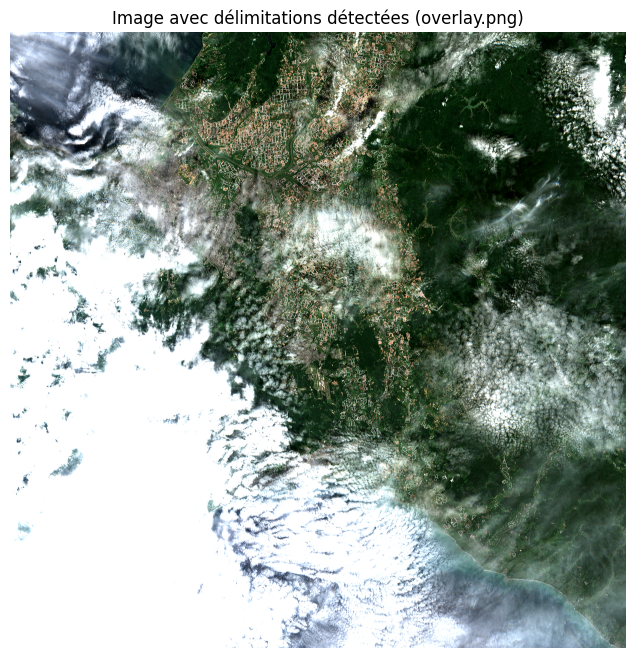

✅ Image affichée avec succès!


In [35]:
from PIL import Image
import matplotlib.pyplot as plt

print("🖼️ Affichage de l'image d'overlay (overlay.png)...")

try:
    # Open the overlay image
    img = Image.open("overlay.png")

    # Display the image using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title("Image avec délimitations détectées (overlay.png)")
    plt.axis('off')
    plt.show()

    print("✅ Image affichée avec succès!")

except FileNotFoundError:
    print("❌ Erreur : Le fichier overlay.png n'a pas été trouvé.")
    print("Veuillez vous assurer que la détection a été exécutée et que le fichier a été généré.")
except Exception as e:
    print(f"❌ Une erreur est survenue lors de l'affichage de l'image : {e}")